<center> 
    <h1>Font Generation using pix2pix</h1>
</center>

<h2>Lab overview</h2>
<a href="https://arxiv.org/pdf/1611.07004.pdf", target="_blank"/>pix2pix</a> was published in 2017 as a solution to image-to-image translation problem using conditional GANs. Using these method we can acomplish many tasks like colorizing black and white photos, converting google maps to google earth, or even generating fonts. For this lab we will build a pix2pix model to learn a domain translation from a source font to a target font. 
<br><br>
This lab uses our custom font dataset and trains a pix2pix on it to later generate fonts in a target font given an input source font. Following are the key points we will cover in this lab.
<ol>
    <li>Import TensorFlow and other libraries </li>
    <li>Prepare and Load the dataset</li>
    <li>Input Pipeline</li>
    <li>Generator and its loss</li>
    <li>Discriminator and its loss</li>
    <li>Define the Optimizers and Checkpoint-saver</li>
    <li>Training</li>
    <li>Restore the latest checkpoint and test</li>
</ol>


<h2>Import TensorFlow and other libraries</h2>

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

import os
import time

from matplotlib import pyplot as plt
from IPython import display

<h2>Prepare and Load the dataset</h2>

Pix2pix model requires a dataset in a paired format i.e. source domain and its corresponding image in target domain. For this lab we have designed our modules that will help us in generating paired font dataset. 
<br>
The goal is to have a source font and a target font. Then we generate font images just like before for both source font and target font. Then we run a module to combine these two domain images. And last we divided them into train and test sets. So now run the following modules to prepare the dataset. Make sure to activate your environment, tutorial-TF in our case. Create a directory structure as below 
<br> <br>
<b>1) Place source and target fonts in their directories</b>
</br>
</br>
<code>
    ├── data_generation
    &nbsp;&nbsp;└── src_font
        &nbsp;&nbsp;├── .ttf
    &nbsp;&nbsp;└── trg_font
        &nbsp;&nbsp;├── .ttf
</code>
<br>
<b>2) Generate source and target font images</b>
<code>
    1) python ./data_generation/tools/Lab4_pix2pix/src-image-generator.py 
    2) python ./data_generation/tools/Lab4_pix2pix/trg-image-generator.py
</code>
Running these two commands will generate two directories in our root directory with name <code>source/images</code> and <code>target/images</code>
<br><br>
<b>3) Combine source and target font images</b>
<code>
    python ./data_generation/tools/Lab4_pix2pix/combine_src_trg_font.py --input_dir source/images --b_dir target/images --operation combine
</code>
Running the above module will combine the images in <code>source/images</code> directory with the <code>target/images</code> directory. The combining module combines the images with same name like <code>1_1.png in source directory</code> will be combined with <code>1_1.png in target directory</code> and strores them in a new directory <code>Lab4-image-data/images</code>. Once the data is generated the module removes the source and target directory.
<br><br>
<b>4) Split into train and test</b>
<code>
    python ./data_generation/tools/Lab4_pix2pix/split.py --dir Lab4-image-data/images
</code>
Running the above module will split our training dataset into train and test in a 90 and 10 % respectively. --dir flag represents the path to the input directory.
<br>
<br>
Ok so far so good. Lets create an input pipeline in TensorFlow to load the data for our model. We will utilize the Dataset api which is an API for input pipelines in TensorFlow.
First we will setup the path of the image directory by running the below code.

In [3]:
# Setting up paths for the input images
SCRIPT_PATH = os.path.join(os.getcwd())
PATH = os.path.join(os.path.dirname(SCRIPT_PATH), 'Lab4-image-data/images/')

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

Here we load a random image from the image directory, and divide the image into input and target images by slicing. Then plot the images after casting.

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

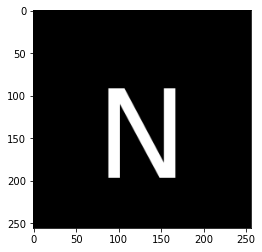

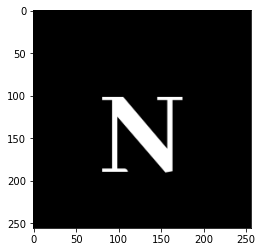

In [6]:
inp, re = load(PATH+'train/1_14.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

<h3> Data Preprocessing functions</h3>
As mentioned in the paper we apply <b>random jittering</b> and <b>mirroring</b> to the training dataset.
<ol>
    <li>In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256</li>
    <li>In random mirroring, the image is randomly flipped horizontally i.e left to right.</li>
</ol>

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring: the image is randomly flipped horizontally i.e left to right.
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

As you can see in the images below that they are going through random jittering Random jittering as described in the paper is to
<ol>
    <li>Resize an image to bigger height and width</li>
    <li>Randomly crop to the target size</li>
    <li>Randomly flip the image horizontally</li>

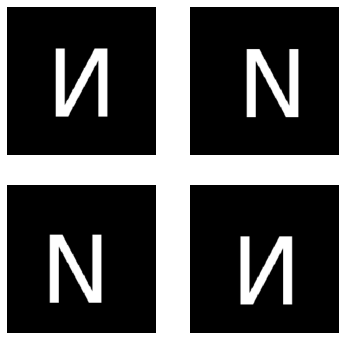

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

Below two are the map functions which will called when we will create our input pipeline. These two are for data preprocessing like random jittering and normalization of images for train and test images.

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

<h2>Input Pipeline</h2>
Lets create our Input pipeline to load train and test dataset for the model.

In [14]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

<h2> Generator and its Loss</h2> 
Let's create our Generator network. Following are some key characterstics of pix2pix generator.
<ol>
    <li>The architecture of generator is a modified U-Net</li>
    <li>Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)</li>
    <li>Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)</li>
    <li>There are skip connections between the encoder and decoder (as in U-Net).</li>
</ol>
<br>
The architecture of pix2pix Generator is shown below.
<br>
<br>
<img src="../Figures/pix2pix_G.jpg" width=800 height=800 />
<br>
<br>


In [16]:
OUTPUT_CHANNELS = 3

In [17]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [18]:
down_model = downsample(3, 4)
# tf.expand_dims() is used to create a space for the batch size as currently the image shape is 256x256x3
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [19]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [21]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
generator = Generator()

<b> Generator Loss</b>
<br>
Following are the characterstics of the Generator's loss function.<br>
<ol>
    <li>It is a sigmoid cross entropy loss of the generated images and an array of ones.</li>
    <li>The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image</li>
    <li>This allows the generated image to become structurally similar to the target image.</li>
    <li>The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.</li>
</ol>

In [23]:
LAMBDA = 100

In [24]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

<h2> Discriminator and its loss</h2>
Following are the characterstics of the pix2pix's Discriminator. <br>
<ol>
    <li>The Discriminator is a PatchGAN.</li>
    <li>Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)</li>
    <li>The shape of the output after the last layer is (batch_size, 30, 30, 1)</li>
    <li>Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).</li>
    <li>Discriminator receives 2 inputs.
        <ul>- Input image and the target image, which it should classify as real.</ul>
        <ul>- Input image and the generated image (output of generator), which it should classify as fake.</ul>
        <ul>- We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))</ul>
    </li>
    

In [25]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [26]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 128, 128, 64) 6144        concatenate_7[0][0]        

<b> Discriminator Loss</b>
<br>
<ol>
    <li>The discriminator loss function takes 2 inputs; real images, generated images</li>
    <li>real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)</li>
    <li>generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)</li>
    <li>Then the total_loss is the sum of real_loss and the generated_loss</li>
</ol>

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown above.

<h2>Define the Optimizers and Checkpoint-saver</h2>

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<h2> Generate Images</h2>
Lets write a simple function to plot some images during training and afterwards.
<ol>
    <li>We pass images from the test dataset to the generator.</li>
    <li>The generator will then translate the input image into the output.</li>
    <li>Last step is to plot the predictions</li>
</ol>
    

In [48]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

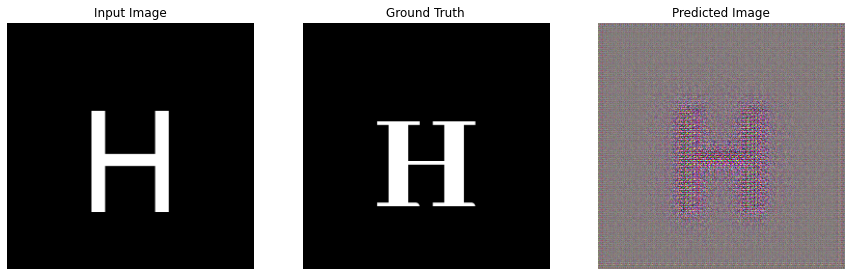

In [49]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

<h2>Training</h2>
<ol>
    <li>For each example input generate an output.</li>
    <li>The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.</li>
    <li>Next, we calculate the generator and the discriminator loss.</li>
    <li>Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.</li>
</ol>

In [51]:
EPOCHS = 1000

In [52]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [53]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:
<ol>
    <li>Iterates over the number of epochs.</li>
    <li>On each epoch it clears the display, and runs generate_images to show it's progress.</li>
    <li>On each epoch it iterates over the training dataset, printing a '.' for each example.</li>
    <li>It saves a checkpoint every 20 epochs.</li>
</ol>

In [54]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

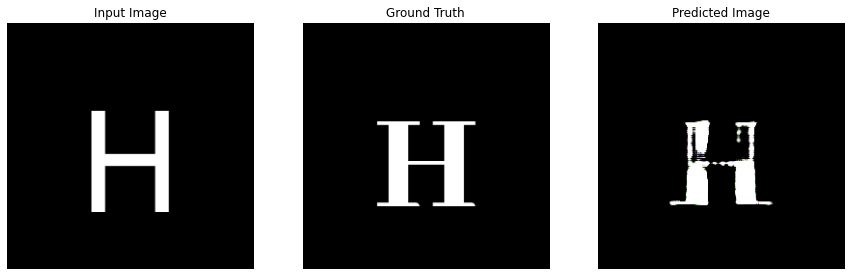

Epoch:  243
...

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

<h2>Restore the latest checkpoint and test</h2>

In [42]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<h2>Generate using test dataset</h2>

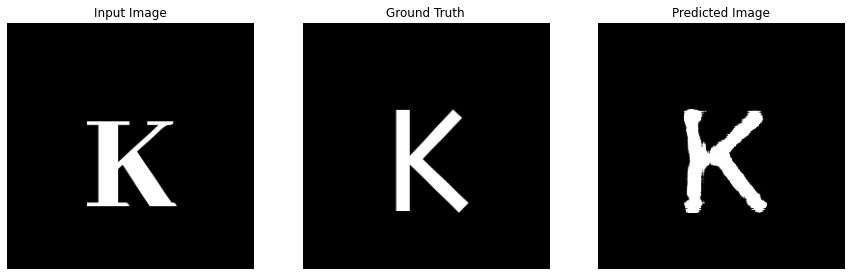

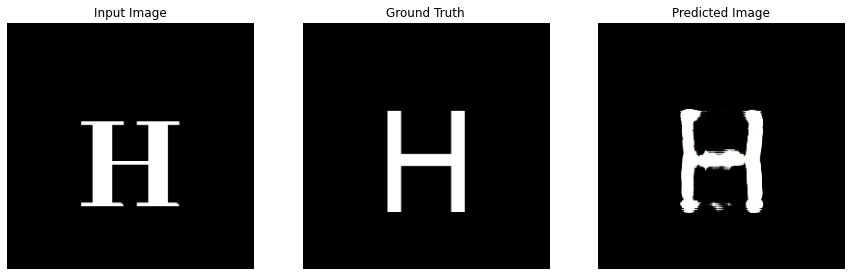

In [43]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)